In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask


In [2]:
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='04:00:00',
    local_directory='$TMPDIR')
cluster

PBSCluster('tcp://10.120.43.36:43549', workers=0, threads=0, memory=0 B)

In [4]:
cluster.scale(40)

In [5]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.43.36:43549 Dashboard: http://10.120.43.36:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
print(len(client.scheduler_info()["workers"]))

20


In [8]:
!qstat -u albert7a

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 30:
        break
    time.sleep(1)
print(nb_workers)

30


In [9]:
import zarr
import netCDF4
import pytide
import xarray as xr
import os
import glob
import numpy as np

In [10]:
%%time
root = "/work/ALT/odatis/eNATL60/BLBT02/gridT-2D/"
files = sorted(glob.glob(root+'/*.nc'))

drop_vars = [
    'nav_lat',
    'nav_lon',
    'somxl010',
    'sosaline',
    'sosstsst']

# these are variables I want to drop while running `open_mfdataset` but then add back later
extra_coord_vars = ['y', 'x']
extra_coord_vars = []

chunks = dict(time_counter=1)

open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
                   chunks=chunks, decode_cf=True, concat_dim="time_counter") #, combine='nested')
ds = xr.open_mfdataset(files, combine='nested',parallel=True, **open_kwargs)


CPU times: user 4.03 s, sys: 134 ms, total: 4.17 s
Wall time: 7.18 s


In [11]:
dsg=xr.open_dataset('/work/ALT/odatis/eNATL60/mesh_mask_eNATL60_3.6_lev1.nc4')

In [12]:
box=(-90,-60,30,45)
domaineNATL60=(box[0]<dsg.nav_lon)*(dsg.nav_lon<box[1])*(box[2]<dsg.nav_lat)*(dsg.nav_lat<box[3])
whereeNATL60=np.where(domaineNATL60)
jmineNATL60 = whereeNATL60[0].min()
jmaxeNATL60 = whereeNATL60[0].max()
imineNATL60 = whereeNATL60[1].min()
imaxeNATL60 = whereeNATL60[1].max()

START_DATE = np.datetime64('2009-07-01')
END_DATE = np.datetime64('2010-07-01')
time_series=ds['time_counter']
period = (time_series >= START_DATE) & (time_series <= END_DATE)
time=time_series[period]
ssh=ds.sossheig[period,jmineNATL60:jmaxeNATL60+1,imineNATL60:imaxeNATL60+1]
t=time.values

In [13]:
%%time
wt = pytide.WaveTable()
wt = pytide.WaveTable(["M2"])
f, vu = wt.compute_nodal_modulations(t)

CPU times: user 7.15 ms, sys: 2.03 ms, total: 9.18 ms
Wall time: 9.39 ms


In [14]:
def dask_array_rechunk(da, axis=0):
    """Search for the optimal block cutting without modifying the axis 'axis'
    in order to optimize its access in memory."""
    nblocks = 1
    
    def calculate_chuncks_size(chunks, size):
        result = np.array(chunks).prod() * size
        return result / (1000**2)
       
    while True:
        chunks = []
        div = int(np.sqrt(nblocks))
        for index, item in enumerate(da.chunks):
            chunks.append(np.array(item).sum() * (div if index == axis else 1))
        chunks = tuple(item // div for index, item in enumerate(chunks))
        chuncks_size = calculate_chuncks_size(chunks, da.dtype.itemsize)
        if chuncks_size > 100 and chuncks_size < 150:
            return chunks
        nblocks += 1

In [15]:
def _apply_along_axis(arr, func1d, func1d_axis, func1d_args, func1d_kwargs):
    """Wrap apply_along_axis"""
    return np.apply_along_axis(func1d, func1d_axis, arr, *func1d_args,
                                  **func1d_kwargs)


def apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """Apply the harmonic analysis to 1-D slices along the given axis."""
    arr = dask.array.core.asarray(arr)

    # Validate and normalize axis.
    arr.shape[axis]
    axis = len(arr.shape[:axis])

    # Rechunk so that analyze is applied over the full axis.
    arr = arr.rechunk(arr.chunks[:axis] + (arr.shape[axis:axis + 1], ) +
                      arr.chunks[axis + 1:])

    # Test out some data with the function.
    test_data = np.ones(args[0].shape[1], dtype=arr.dtype)
    test_result = np.array(func1d(test_data, *args, **kwargs))

    # Map analyze over the data to get the result
    # Adds other axes as needed.
    result = arr.map_blocks(
        _apply_along_axis,
        name=dask.utils.funcname(func1d) + '-along-axis',
        dtype=test_result.dtype,
        chunks=(arr.chunks[:axis] + test_result.shape + arr.chunks[axis + 1:]),
        drop_axis=axis,
        new_axis=list(range(axis, axis + test_result.ndim, 1)),
        func1d=func1d,
        func1d_axis=axis,
        func1d_args=args,
        func1d_kwargs=kwargs,
    )

    return result

In [16]:
ssh_rechunk = ssh.chunk(dask_array_rechunk(ssh))
future = apply_along_axis(pytide.WaveTable.harmonic_analysis, 0, ssh_rechunk,
                          *(f, vu))


In [17]:
len(future.dask)

70427

In [18]:
%%time
analysis = future.compute()

CPU times: user 1min 46s, sys: 4.76 s, total: 1min 51s
Wall time: 6min 31s


In [19]:
%%time
amp_da=xr.DataArray(np.absolute(analysis),dims={'freq','y','x'},name='tidal-amp')
amp_da.to_netcdf(path='/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tidal_amp_M2_y2009m07-y2010m06.nc',engine='scipy')

phase_da=xr.DataArray(np.angle(analysis),dims={'freq','y','x'},name='tidal-phase')
phase_da.to_netcdf(path='/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tidal_phase_M2_y2009m07-y2010m06.nc',engine='scipy')

CPU times: user 220 ms, sys: 57.5 ms, total: 278 ms
Wall time: 507 ms


In [20]:
nwaves, ni, nj = analysis.shape
tide = wt.tide_from_mapping(
    time_series[0].astype('datetime64[s]').astype('float64'),
    analysis.reshape(nwaves, ni*nj)).reshape(ni, nj)

In [21]:
tide.shape

(1290, 1825)

In [22]:
total_ssh=ssh[0]
detided_ssh=total_ssh-tide

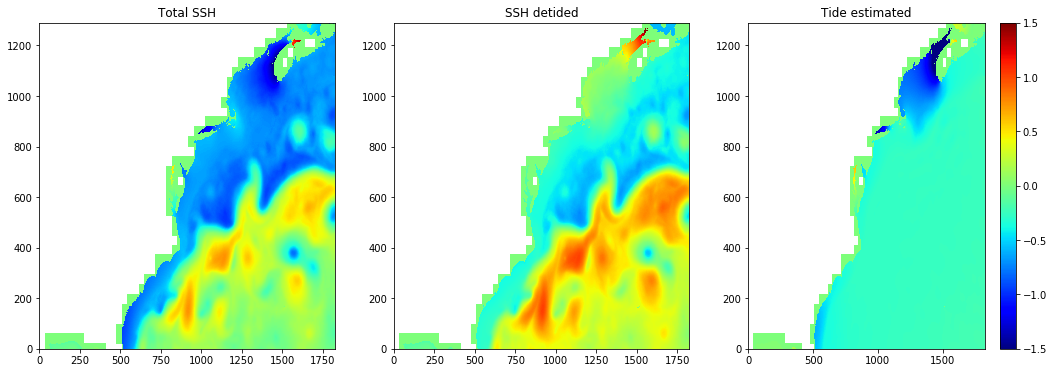

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.pcolormesh(total_ssh, vmin=-1.5, vmax=1.5,cmap='jet')
ax1.set_title("Total SSH")
ax2.pcolormesh(detided_ssh, vmin=-1.5, vmax=1.5, cmap='jet')
ax2.set_title("SSH detided")
pcolor=ax3.pcolormesh(tide, vmin=-1.5, vmax=1.5, cmap='jet')
ax3.set_title("Tide estimated")
fig.colorbar(pcolor)

In [30]:
%%time
nt=len(time)
nwaves, ni, nj = analysis.shape
for k in np.arange(len(time)):
    if not os.path.exists('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tide_time_M2_y2009m07-y2010m06_k'+str(k)+'.nc'):
        ttide = wt.tide_from_mapping(time[k].astype('datetime64[s]').astype('float64'),analysis.reshape(nwaves, ni*nj)).reshape(ni, nj)
        ttide_da=xr.DataArray(ttide,dims={'y','x'},name='tide')
        ttide_newcoord = ttide_da.assign_coords(time_counter=time[k])
        ttide_da_expanded = ttide_newcoord.expand_dims('time_counter')
        ttide_da_expanded.to_netcdf(path='/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tide_time_M2_y2009m07-y2010m06_k'+str(k)+'.nc',engine='scipy')


CPU times: user 20min 53s, sys: 2min 17s, total: 23min 11s
Wall time: 24min 23s


In [39]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
